<a href="https://colab.research.google.com/github/KapilKhanal/AdvLinearAlgebra/blob/master/Project_4_Case_1_Solving_for_a_known_trigonometric_function_using_Singular_Values_or_Best_Fit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#  Libraries that we'll need:
import numpy as np
import sympy as sym
#from scipy import misc
from scipy import linalg
#from PIL import Image
#import imageio
import matplotlib.pyplot as plt
# importing "random" for random operations 
import random 

#  Singular Value Decomposition and Best Fit

We look at some data generated here from three sources:

*   Case 0:  A known polynomial function $f(x) = 4 - 3x^2 + 5x^6$
*   Case 1:  A known trigonometric function $f(x) = 4 - 2cos(x) + cos^2 (x)$
*   Case 2:  A matrix of data $M$ (specified below) with unknown source function
*   Case 3:  An interesting case.

#  Overview for Case 1: A known trigonometric function $f(x) = 4 - 2\cos(x) + \cos^2(x)$  
We generate data for the polynomial function 
$$f(x) = 4 -3\cos(x) + \cos^2 (x)$$ 
We know two things: The input (x) and the output (f(x)) for that input.  Pretend we know the (x, f(x)) pairs for **a lot** of different points, say $3$ of them.

We want to find out what combination of polynomials $1, x, x^2, x^3, x^4, x^5, x^6, x^7$ and $x^8$ best matches the data.  For each input/output pair $(x, f(x))$, we generate one row of data in the system $Ac = b$:

$$ [  c_0 * 1 + c_1 * x + c_2 * x^2 + c_3 * x^3 + ... c_8 x^8 = f(x) ] $$

or

$$ \left[ \begin{array}{ccccccccc} 1 & x & x^2 & x^3 & x^4 & x^5 & x^6 & x^7 & x^8 \end{array} \right] \left( \begin{array}{c} c_0 \\ c_1 \\ c_2 \\ c_3 \\ c_4 \\ c_5 \\c_6 \\ c7 \\ c8 \\ \end{array} \right) = \left[ f(x) \right] $$


Be careful -- the unknowns are the coefficients in front - the $c_0, c_1, c_2, ..., c_8$ values.  Since we know $x$, then we know $x, x^2, x^3, x^4, ... x^8$. And we know the output $f(x)$ for that row.

So, if we know $x=2$ and $f(2) = 312$, then we populate the row as:

$$ [  c_0*1  + c_1*2 + c_2*4 + c_3*8 + ... + c_8*256 = 312 ] $$

or
$$ \left[ \begin{array}{ccccccccc} 1 & 2 & 4 & 8 & 16 & x32 & 64 & 128 & 256\end{array} \right] \left( \begin{array}{c} c_0 \\ c_1 \\ c_2 \\ c_3 \\ c_4 \\ c_5 \\c_6 \\ c_6 \\ c_8 \\ \end{array} \right) = \left[ 312 \right] $$

where the vector $\vec{c}$ contains the unknowns $c_0, c_1, c_2, \ldots c_8$

So... let's generate the matrix:



#1.1 Setting up the system

We'll generate some data points for our system using the function 
$$ f(x) = 4 - 2\cos(x) + \cos^2(x)$$

We'll store the input data in **actual_data_x** and the output in **actual_data_y**.

We'll also use the data to set up a system
$$M \vec{x} = \vec{b}$$

where **actual_data_x** is used to populate matrix $M$ and **actual_data_y** is used to populate $\vec{b}$.

In [0]:
#We'll generate random points of data for our system.
#The actual points for the system will be stored in containers actual_data_x and actual_data_y

actual_data_x = []
actual_data_y = []

#We'll use (cough... cough...) three   data points:
for i in range(3):
    # pick a random number between -2pi and 2pi
    x = 4*np.pi*random.random() - 2*np.pi
    f = 4 - 2*np.cos(x) + np.cos(x)**2
    actual_data_x.append(x)
    actual_data_y.append(f)

In [0]:
# uncomment code below  to look at the data in actual_data_x or in actual_data_y

#actual_data_x
#actual_data_y

In [0]:
#Create the matrix M from the data in actual_data_x
M_entries = []

for x in actual_data_x:
  M_entries.append([1, x, x**2, x**3, x**4, x**5, x**6, x**7, x**8])

M = []
M = np.matrix(M_entries)


#and create the vector b from the data in actual_data_y:
b = []
b = (np.matrix(actual_data_y)).transpose()

In [12]:
# Uncomment either line below to show the matrix M
# or the first five entries of b

M
b[:5]

matrix([[6.60571282],
        [4.03353266],
        [5.83103737]])

#1.2:  Plot the generated system:

We'll create a plot showing the function (in red) and the data points sampled for the function (in blue).

To generate the graph of the function $f(x)$, we first use $100$ data points from $0$ to $99$, then compress them into an interval of width $6$, and shift it left so that the 100 data points are equally spaced between $x = -2\pi$ and $x=2\pi$.

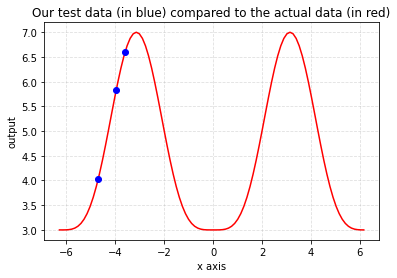

In [13]:
# We'll specify that x is a variable:
x = sym.symbols('x')

xdata = []
fdata = []

#set up our 100 data points on the interval from (-2pi, 2pi):
xdata = np.array(range(100))/(100/(4*np.pi)) - 2*np.pi
# find the ouput for our function on each data point:
fdata = 4 - 2*np.cos(xdata) + np.cos(xdata)**2

# Create the plot in red, and our datapoints in blue:  
plt.plot(xdata,fdata, color='red') + plt.plot(actual_data_x, actual_data_y, 'bo')

# Add a title
plt.title('Our test data (in blue) compared to the actual data (in red)')

# Add X and y Label
plt.xlabel('x axis')
plt.ylabel('output')

# Add a grid
plt.grid(alpha=.4,linestyle='--')


#1.3:  Solving the system using the method of Best-Fit:

Given a system 
$$ M \vec{x} = \vec{b}$$

where matrix $M$ is **not necessarily square**, we can multiply by $M^T$ on the left to form the system

$$ \left( M^T M \right) \vec{x} = M^T \vec{b} $$

Now, $M^T M$ is a square matrix, so we can use it's inverse to solve for $\vec{x}$:

$$ \vec{x} = \left( M^T M \right)^{-1} M^T \vec{b}$$

This solution method is called the method of Best-Fit.

**A word of caution**:  We're initially trying to fit a 6th degree polynomial with only 3 data points.  That shouldn't have a good solution, and it could have no solution.  If you get no solution, start at the top and re-run the code to generate a new set of random data points for our system.

In [14]:
#  Find the solution to Mx = b using Best Fit:
#  (We've already used 'x' as a variable, so we'll call the solution vector c.)
c = linalg.inv(M.transpose() * M) * M.transpose() * b
c

matrix([[ 9.07637935e+00],
        [ 1.18776888e-01],
        [ 2.34831683e-01],
        [ 8.72100134e-02],
        [ 2.00741611e-02],
        [ 2.51620992e-03],
        [-1.21977480e-03],
        [-3.95885124e-06],
        [ 4.19187820e-05]])

We can test our solution against the output of our original system.

The original output in our system is represented by $\vec{b}$.

Our suggested solution to $M\vec{x} = \vec{b}$ is $\vec{c}$.  That is, we think

$$ M \vec{c} \approx \vec{b}$$

If we have a good fit, then 

$$\vec{b} - M \vec{c} \approx 0$$

To test our solution, we find the) magnitude of $\vec{b} - M\vec{c}$:

In [15]:
#  Let's see how close this actually gets us by comparing the original b vector to the result of Mc:
error = ((b-M*c).transpose() * (b-M*c))[0,0]
error**0.5

2.6252657431368585

We can plot the actual solution (in red) with our best-fit solution (in green), using the test data shown as blue points.  It may be helpful to adjust the limits on the y-axis to zoom in or out on the output.


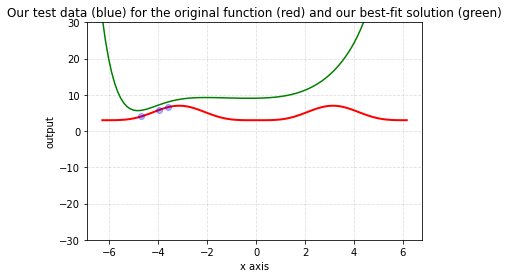

In [17]:
#Show a plot of the solutions using the best-fit method, and the SVD method:

# We'll specify that x is a variable:
x = sym.symbols('x')

xdata = []
fdata = []
#set up our 100 data points on the interval from (-2pi, 2pi):
xdata = np.array(range(100))/(100/(4*np.pi)) - 2*np.pi
# find the ouput for our function on each data point:
fdata = 4 - 2*np.cos(xdata) + np.cos(xdata)**2

best_fit = c[0,0] + c[1,0]*xdata + c[2,0]*(xdata**2) + c[3,0]*(xdata**3) + c[4,0]*(xdata**4) + c[5,0]*(xdata**5) + c[6,0]*(xdata**6) + c[7,0]*(xdata**7) + c[8,0]*(xdata**8)
# Create the actual plot in red, and our datapoints in blue,
# and the best-fit method in green:  
plt.plot(xdata,fdata, color='red', linewidth=2 ) + plt.plot(actual_data_x, actual_data_y, 'bo', alpha=0.3)+plt.plot(xdata,best_fit, color='green')

#Restrict the output values to this range:
plt.ylim(-30,30)

# Add a title
plt.title('Our test data (blue) for the original function (red) and our best-fit solution (green)')

# Add X and y Label
plt.xlabel('x axis')
plt.ylabel('output')

# Add a grid
plt.grid(alpha=.4,linestyle='--')

#1.4 Solving the system using Singular Value Decomposition

Singular Value Decomposition decomposes a matrix M into three matrices

$$ M = U \Sigma V^\dagger$$

where $U$ and $V$ are square matrices and $\Sigma$ is a rectangular matrix with singular values on the main diagonal.

In [0]:
#  For this method, we use SVD on the data matrix M:
U, S, Vh = linalg.svd(M, full_matrices=True)
Vh = Vh.T

In [0]:
#  Uncomment the lines below to show the matrix U, S, and Vh:
#  Notice that in S only the singular values are stored, not the entire matrix.
#U
#S
#Vh

In [0]:
#  The 2nd singular value is:
S[1]

In [19]:
# We can compare the original matrix M to the matrix reconstructed (called a1) from the SVD:
# If they are close, then allclose(M, a1) should be True.

#First, recast S as a matrix instead of a vector:
sigma = np.zeros((U.shape[1], Vh.shape[0]))
for i in range(min(sigma.shape)):
     sigma[i, i] = S[i]
a1 = np.dot(U, np.dot(sigma, Vh))
#does a1 approximate M?
np.allclose(M, a1)

False

The SVD decomposition of matrix $M$ may have non-zero singular values in $\Sigma.  To solve
$$ M \vec{x} = \vec{b}$$

we can replace $M$ with $U \Sigma V^\dagger$:
$$ U \, \Sigma \, V^\dagger \, \vec{x} = \vec{b}$$

The inverse of matrices $U$ and $V$ are $U^\dagger$ and $V^\dagger$.  If we decompose $\Sigma$ into a block matrix composed of the non-zero singular values, then we can restrict our singular value decomposition into invertible and non-invertible parts:

$$ U \, \Sigma \, V^\dagger = \left( \begin{array}{c|c} U_{use} & U_{discard} \\ \end{array} \right) \left( \begin{array}{c|c} \Sigma_{use} & 0 \\ \hline 0 & \Sigma_{discard} \\ \end{array} \right)  \left( \begin{array}{c|c} V_{use} & V_{discard} \\ \end{array} \right)^\dagger$$

Effectively, this allows us to replace $U \Sigma V^\dagger \vec{x} = \vec{b}$ with

$$ U_{use} \, \Sigma_{use} \, V_{use}^\dagger \, \vec{x} = \vec{b}$$

The solution to this system is then

$$\vec{x} = V_{use} \, \Sigma_{use}^{-1} \, U_{use}^\dagger \, \vec{b}$$


In [0]:
#  Based on the number of non-zero singular values in S, divide each of U, sigma, and Vh into 
#  U_use, Sigma_use, and Vh_use.
#  and  discard U_d, Sigma_d, Vh_d
useSigs = 3

#Use these parts of U, S, and Vh
(Vrows, Vcols) = Vh.shape
(Urows, Ucols) = U.shape
U_use = U[:Urows, :useSigs]
Vh_use = Vh[:Vrows, :useSigs]
sigma_use = sigma[:useSigs, :useSigs]

#discard these parts of U, S, and Vh:
U_d = U[:Urows, useSigs:]
Vh_d = Vh[:Vrows, useSigs:]
sigma_d = sigma[useSigs:, useSigs:]

In [0]:
#  We should be able to figure out the size of U and Vh that we'll use:
#
#  U S Vh  =   [         .     ] [             .         ]  [            .      ]
#              [ U_use   .     ] [  sigma_use  .         ]  [   Vh_use   .      ]
#              [         . U_d ] [.......................]  [            . Vh_d ]
#              [         .     ] [             . sigma_d ]  [            .      ]
#
#
#  Check that U_use, sigma_use, and Vh_use are the right sizes, as well as U_d, sigma_d, and Vh_d
#U_use.shape
#sigma_use.shape
#Vh_use.shape
#U_d.shape
#sigma_d.shape
#Vh_d.shape

In [21]:
#  If we use Singular Value Decomposition to break down M as a product of matrices
#  M = U sigma Vh.conjugate_transpose()
#  Then the part of A which corresponds to non-zero singular values is:
#  M_use = U_use sigma_use Vh_use.conjugate_transpose()
#
#  So, the equation Mx = b becomes:  (U_use sigma_use Vh_use.conjugate_transpose()) x = b
#  or
#  svd_sol = (U_use sigma_use Vh_use.conjugate_transpose()).inverse() b
#  or
#  svd_sol = Vh_use * Sigma_use.inverse() * U_use.transpose() * b
#  (since Vh_use.conjugate_transpose() = Vh_use.inverse() and U_use.transpose() = U_use.inverse() )
svdsol = (Vh_use @ linalg.inv(sigma_use) @ U_use.transpose()) @ b
svdsol

matrix([[ 0.00024403],
        [-0.00072442],
        [ 0.00204904],
        [-0.005403  ],
        [ 0.01275597],
        [-0.02465425],
        [ 0.02910395],
        [ 0.0162938 ],
        [ 0.00190014]])

We can test our solution against the output of our original system.

The original output in our system is represented by $\vec{b}$.

Our suggested solution to $M\vec{x} = \vec{b}$ is $\vec{svdsol}$.  That is, we think

$$ M \vec{svdsol} \approx \vec{b}$$

If we have a good fit, then 

$$\vec{b} - M \vec{svdsol} \approx 0$$

To test our solution, we find the) magnitude of $\vec{b} - M\vec{svdsol}$:

In [22]:
#  Let's see how close this actually gets us by comparing the original b vector to the result of Mc:
error = ((b-M*svdsol).transpose() * (b-M*svdsol))[0,0]
error**0.5

3.1359742465361133e-13

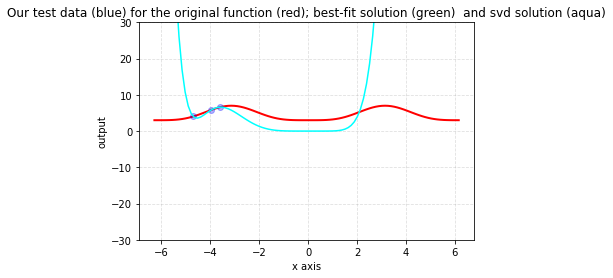

In [24]:
#Show a plot of the solutions using the best-fit method, and the SVD method:

# We'll specify that x is a variable:
x = sym.symbols('x')

xdata = []
fdata = []
#set up our 100 data points on the interval from (-2pi, 2pi):
xdata = np.array(range(100))/(100/(4*np.pi)) - 2*np.pi

# find the ouput for our function on each data point:
fdata = 4 - 2*np.cos(xdata) + np.cos(xdata)**2

#construct the solution from svdsol
svd_fit = svdsol[0,0] + svdsol[1,0]*xdata + svdsol[2,0]*(xdata**2) + svdsol[3,0]*(xdata**3) + svdsol[4,0]*(xdata**4) + svdsol[5,0]*(xdata**5) + svdsol[6,0]*(xdata**6) + svdsol[7,0]*(xdata**7)+svdsol[8,0]*(xdata**8)
# Create the actual plot in red, and our datapoints in blue,
# and the svd solution in aqua:  
plt.plot(xdata,fdata, color='red', linewidth=2 ) + plt.plot(actual_data_x, actual_data_y, 'bo', alpha=0.3) + plt.plot(xdata, svd_fit, 'aqua')

#Restrict the output values to this range:
plt.ylim(-30,30)
# Add a title
plt.title('Our test data (blue) for the original function (red); best-fit solution (green)  and svd solution (aqua)')

# Add X and y Label
plt.xlabel('x axis')
plt.ylabel('output')

# Add a grid
plt.grid(alpha=.4,linestyle='--')


#1.5  Finding a better solution


Both the above solutions give really bad approximations to the polynomial  
$$f(x) = 4 - 2\cos(x) + \cos^2(x)$$

Why?  We only used three data points for our data.  Go back and modify the code so that you use *MORE DATA*

(Hint:  You have to change two of the '3' numbers in the code above:  One to generate more data; the other to use the right number of singular values for your data)

The graph below should show both the best-fit and svd solution:

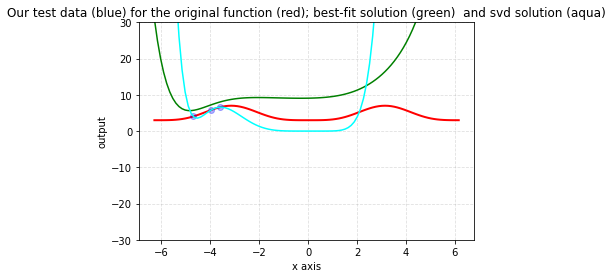

In [25]:
#Show a plot of the solutions using the best-fit method, and the SVD method:

# We'll specify that x is a variable:
x = sym.symbols('x')

xdata = []
fdata = []
#set up our 100 data points on the interval from (-2pi, 2pi):
xdata = np.array(range(100))/(100/(4*np.pi)) - 2*np.pi

# find the ouput for our function on each data point:
fdata = 4 - 2*np.cos(xdata) + np.cos(xdata)**2

#construct the solution from svdsol
svd_fit = svdsol[0,0] + svdsol[1,0]*xdata + svdsol[2,0]*(xdata**2) + svdsol[3,0]*(xdata**3) + svdsol[4,0]*(xdata**4) + svdsol[5,0]*(xdata**5) + svdsol[6,0]*(xdata**6) + svdsol[7,0]*(xdata**7)+svdsol[8,0]*(xdata**8)
#construct the solution from bestfit
best_fit = c[0,0] + c[1,0]*xdata + c[2,0]*(xdata**2) + c[3,0]*(xdata**3) + c[4,0]*(xdata**4) + c[5,0]*(xdata**5) + c[6,0]*(xdata**6) + c[7,0]*(xdata**7) + c[8,0]*(xdata**8)
# Create the actual plot in red, and our datapoints in blue,
# the best-fit method in green, and the svd solution in aqua:  
plt.plot(xdata,fdata, color='red', linewidth=2 ) + plt.plot(actual_data_x, actual_data_y, 'bo', alpha=0.3)+plt.plot(xdata,best_fit, color='green') + plt.plot(xdata, svd_fit, 'aqua')

#Restrict the output values to this range:
plt.ylim(-30,30)
# Add a title
plt.title('Our test data (blue) for the original function (red); best-fit solution (green)  and svd solution (aqua)')

# Add X and y Label
plt.xlabel('x axis')
plt.ylabel('output')

# Add a grid
plt.grid(alpha=.4,linestyle='--')